# Purpose of this simulation


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tables

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('talk')

# ideas

In [2]:
#for comparision
#data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'

data_dump_folders = [
    '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/neurons_128/run_2/',
    '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'
]
    
data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/neurons_128/run_2/'
exp_conds = ['wo_FS_0.7', 'iter_0.7', 'same_0.7']

for e in exp_conds: print(e)

wo_FS_0.7
iter_0.7
same_0.7


# Preproc the feature files

In [10]:
import aopy
import tables
import os

def load_feature_selection_file(data_dump_folders, exp_conds):
    """
    load feature selection from data dump folder
    
    Args:
        data_dump_folder: 
    
    Returns:
        exp_data_all: a list of exp_data as parsed by bmi3d
        exp_data_metadata_all: a list of exp_metadata as parsed by bmi3d
    """

    exp_data_all = list()
    exp_data_metadata_all = list()
    

    
    for data_dump_folder in data_dump_folders:

        for e in exp_conds:
            files = {'hdf':e+'.h5'}
            file_name = files['hdf']

            try:
                d,m = aopy.preproc.parse_bmi3d(data_dump_folder, files)

                #also load the clda and feature selection files
                feature_selection_data = aopy.data.load_hdf_group(data_dump_folder, file_name,'feature_selection')
                d['feature_selection'] =  feature_selection_data

                exp_data_all.append(d)
                exp_data_metadata_all.append(m)

            except:
                print(f'cannot parse {e}')

        
    return (exp_data_all, exp_data_metadata_all)

def load_feature_selection_files(data_dump_folders, exp_conds):
    """
    
    """
    
    exp_data_all = list()
    exp_data_metadata_all = list()
    
    
    if data_dump_folders is not list:
        data_dump_folders = [data_dump_folders]
        
    for d in data_dump_folders:
        
        e, d = load_feature_selection_file(d, exp_conds)
        exp_data_all.extend(e)
        exp_data_metadata_all.extend(d)
        
    
    return  (exp_data_all, exp_data_metadata_all)
        
        
        

In [4]:
data_dump_folders

['/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/neurons_128/run_2/',
 '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/']

In [11]:

(exp_data_all, exp_data_metadata_all) = load_feature_selection_files(data_dump_folders, exp_conds)
    
    
len(exp_data_all)


6

3

In [5]:
exp_data_all[0]['bmi3d_task'].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (128, 1)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (128, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('trial', '<u4', (1,)), ('plant_visible', '?', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

In [6]:
exp_data_all[0]['events'].dtype

dtype([('time', '<u8'), ('event', 'S32'), ('data', '<u4'), ('code', 'u1'), ('timestamp_bmi3d', '<f8'), ('timestamp', '<f8')])

In [7]:
no_noise_neuron_ind = exp_data_all[0]['feature_selection']['no_noise_neuron_ind']
noise_neuron_ind = exp_data_all[0]['feature_selection']['noise_neuron_ind']

no_noise_neuron_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

# Check feature selection strategies

## display the strategies

In [22]:
def plot_feature_selection(active_feat_set_list, ax = None):
    """
    plot the selection strategy map. 
    """
    from matplotlib import colors
    
    
        
    active_feat_heat_map = np.array(active_feat_set_list, dtype = np.int32)
    active_feat_heat_map = np.ma.masked_where(active_feat_heat_map == False, active_feat_heat_map)
    

    
    if ax is None: 
        fig, ax = plt.subplots()
        print(type(ax))
        
        #color true to yellow
    cmap = colors.ListedColormap(['yellow'])
    ax.imshow(active_feat_heat_map.T, cmap = cmap)

   
    cmap.set_bad(color='blue')

    ax.set_xlabel('Learner batch')
    ax.set_ylabel('Feature index')





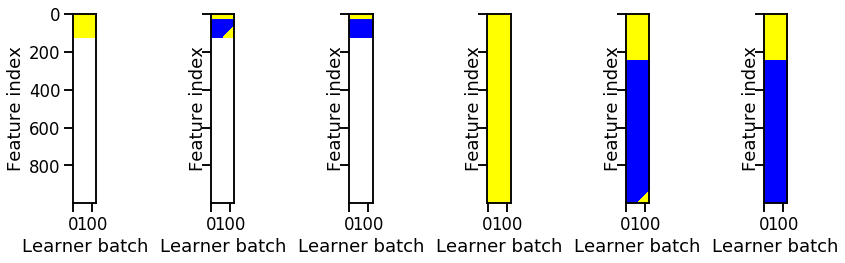

In [23]:
fig_feat_activity, ax_feat_activity = plt.subplots(1,6, figsize = 
                                                   (3 * 4, 4), sharey = True)

for e, a in zip(exp_data_all,  ax_feat_activity):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    
    
fig_feat_activity.tight_layout()


# Behaviour comparision

## count how many rewards

## Trial segments and trajectories

In [10]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239


def get_all_cursor_trajectories(exp_data_all, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    cursor_trajectories_list = []
    
    for e in exp_data_all:
        (cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(e, start_code = start_code, end_codes=end_codes)
        cursor_trajectories_list.append(cursor_trajectories)
    return cursor_trajectories_list

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, start_code,  end_codes)
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [11]:
start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)

range(17, 24)


In [12]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)


#calc_trial_times(trial_times)

In [13]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

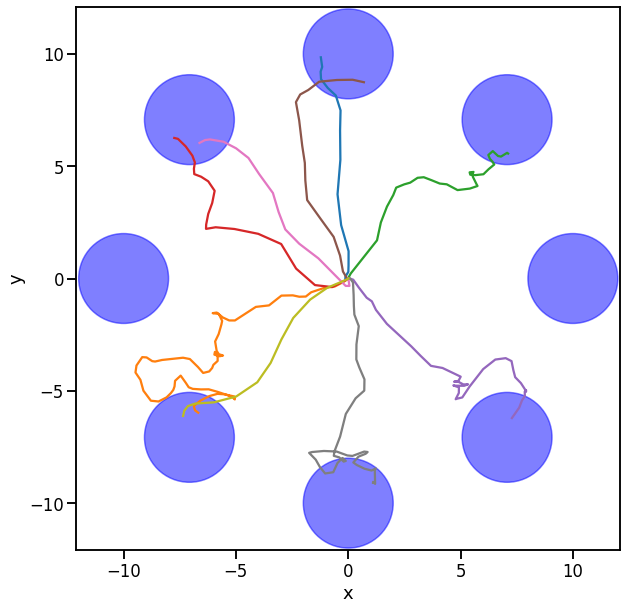

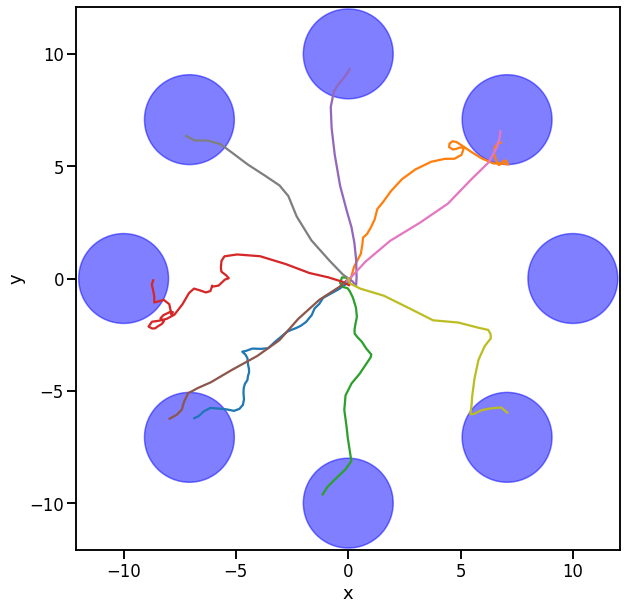

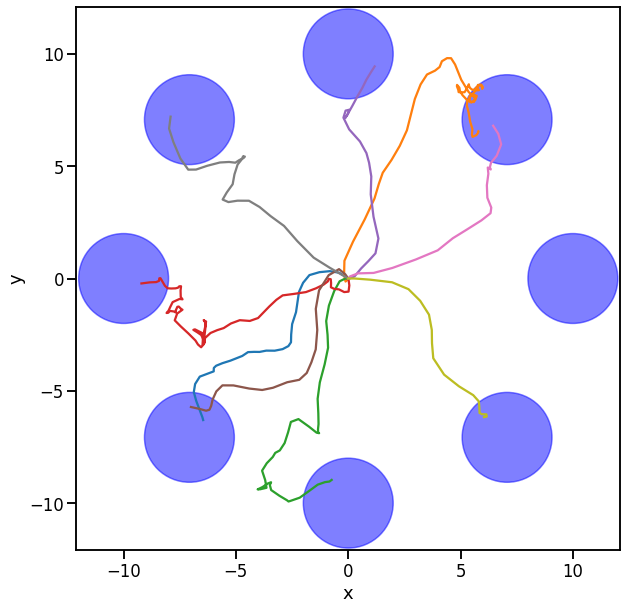

In [14]:
for c in cursor_trajectories_list:
    plot_cursor_trajectories(c[1:10], exp_data_all[0], exp_data_metadata_all[0])

# Post data analysis

# Behaviour  analyses

## Trajectory analysis

In [15]:
def calculate_traj_length(trajectories):
    """
    given a list of trajectories, calculate each trajectory's length
    
    args:
        trajectories[np.ndarray]: number of data points by number of dims
    """
    traj_length = np.empty((len(trajectories)))
    
    for i,t in enumerate(trajectories):
        delta = np.diff(t, axis = 0)
        
        
        delta_length = delta**2
        
        
        delta_sum = np.sum(delta_length, axis = 1) ** (1/2)
        
        delta_sum = np.sum(delta_sum)
        
        traj_length[i] = delta_sum
        
    return traj_length
        
        

def test_calculate_traj_length():
    
    
    #test a line segment length
    cursor_trajectory = np.arange(0,1, 0.1).reshape(-1,1)
    expected_trajectory_length = np.array([0.9])
    calculated_trajectory_length = calculate_traj_length([cursor_trajectory])
    
    np.testing.assert_array_equal(expected_trajectory_length, calculated_trajectory_length)
    
    
test_calculate_traj_length()    

Text(0.5, 0, 'Trial #')

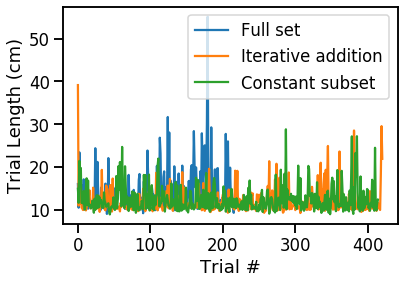

In [16]:

 
cursor_length = [calculate_traj_length(t) for t in cursor_trajectories_list]

for c in cursor_length:
    plt.plot(c)
    
plt.legend(['Full set','Iterative addition', 'Constant subset'])
plt.ylabel('Trial Length (cm)')

plt.xlabel('Trial #')

## Variance analysis

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [17]:
clda_log = exp_data_all[0]['bmi3d_clda']


In [18]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

In [19]:
print(clda_log['kf_C'][-1])

[[ 0.       0.       0.       4.43452  0.       0.79306 34.1055 ]
 [ 0.       0.       0.       0.70474  0.       2.61652 34.99367]
 [ 0.       0.       0.      -2.92893  0.       0.79235 36.03123]
 [ 0.       0.       0.       0.94715  0.      -2.37551 36.71722]
 [ 0.       0.       0.       4.43158  0.      -0.91491 36.92641]
 [ 0.       0.       0.       1.62274  0.       2.8482  39.18741]
 [ 0.       0.       0.      -1.7401   0.      -0.90429 36.29739]
 [ 0.       0.       0.       1.48451  0.      -3.2065  31.89967]
 [ 0.       0.       0.       5.29427  0.       0.05341 32.98776]
 [ 0.       0.       0.       0.71435  0.       4.20727 38.05347]
 [ 0.       0.       0.      -2.62463  0.      -0.41952 38.54844]
 [ 0.       0.       0.       0.48475  0.      -3.63209 38.42409]
 [ 0.       0.       0.       4.37189  0.       1.12061 28.86869]
 [ 0.       0.       0.       1.4175   0.       2.95814 31.12232]
 [ 0.       0.       0.      -1.13481  0.       1.73839 30.26709]
 [ 0.     

## decoder

In [20]:
exp_data_all[0]['feature_selection'].keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'n_starting_feats', 'n_states', 'no_noise_neuron_ind', 'noise_mode', 'noise_neuron_ind', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

(121, 128, 7)


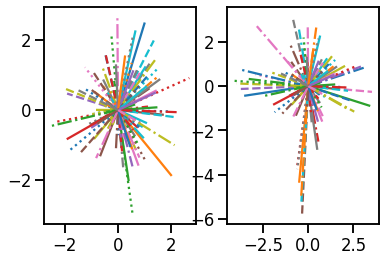

In [21]:
from afs_plotting import plot_prefered_directions

C_mat = exp_data_all[2]['feature_selection']['C_mat']

print(C_mat.shape)



fig, ax = plt.subplots(1,2)

plot_prefered_directions(C_mat[0], ax = ax[0])
plot_prefered_directions(C_mat[-1], ax = ax[1])

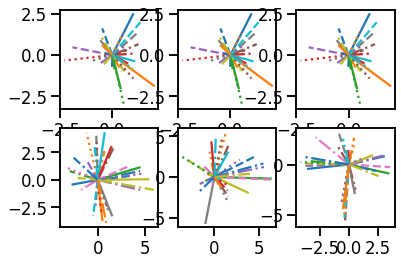

In [22]:
from afs_plotting import plot_prefered_directions

def plot_all_initial_C_mat(exp_data_all, selected_neuron = 'all',debug = True):
    
    """
    just compare initial C mat with the last C_mat
    """
    
    N_EXP = len(exp_data_all)
    
    fig, ax = plt.subplots(2, N_EXP)
    
    for i in range(N_EXP):
        C_mat = exp_data_all[i]['feature_selection']['C_mat']
        plot_prefered_directions(C_mat[0][no_noise_neuron_ind,:], ax = ax[0,i])
        plot_prefered_directions(C_mat[-1][no_noise_neuron_ind,:], ax = ax[1,i])
        

plot_all_initial_C_mat(exp_data_all)


## Decoder compared to the encoder



In [23]:
exp_data_all[0].keys()

dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

(121, 128, 7)
(121, 128, 7)
(121, 128, 7)


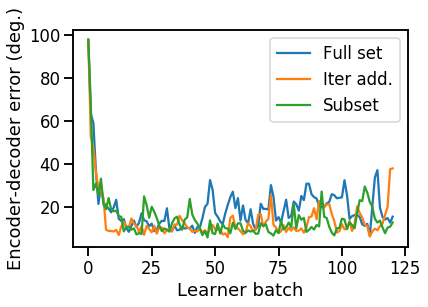

In [24]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix



for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['C_mat']
    
    print(dec_directions.shape)

    angles_hist = calc_cosine_to_target_matrix(dec_directions, enc_directions)
    
#     if i == 0:
#         active_angles = np.mean(angles_hist[:,noise_neuron_list], axis = 1)
#         plt.plot(active_angles)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    
    plt.plot(active_angles)

plt.xlabel('Learner batch')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

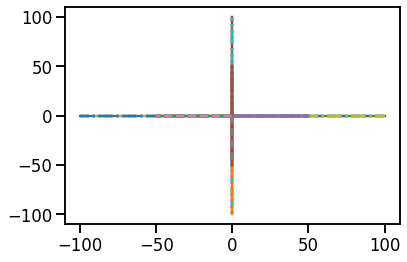

In [25]:
plot_prefered_directions(enc_directions)

## looking at K matrix

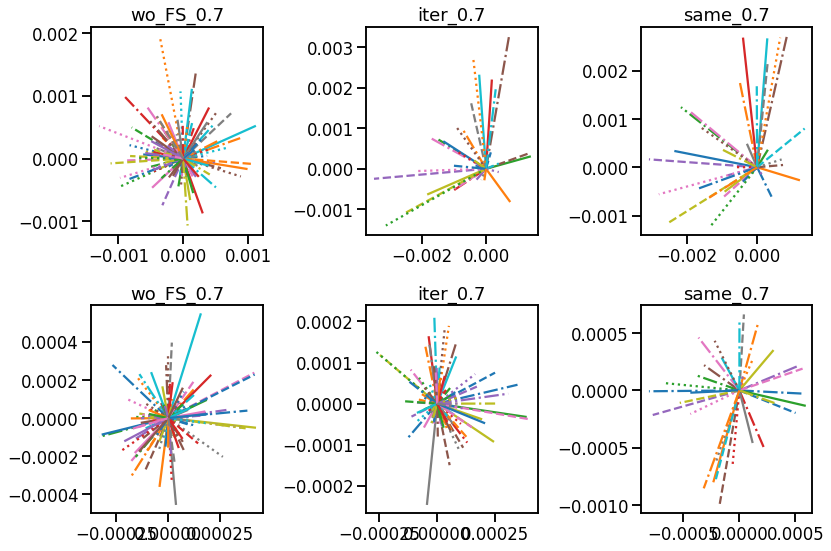

In [26]:
NUM_EXP = 3
GLOBAL_FIGURE_VERTICAL_SIZE  = 4

figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))



#compare the K matrix before the exp
for i,e in enumerate(exp_conds):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    K = K_mat[1].T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i], plot_states = [0,2])
    axes_k_matrix[0, i].set_title(exp_conds[i])

#compare to the matrix after the exp
for i,e in enumerate(exp_conds):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    
    K = K_mat[-1].T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i], plot_states = [0,2])
    axes_k_matrix[1,i].set_title(exp_conds[i])
figure_k_matrix.tight_layout()

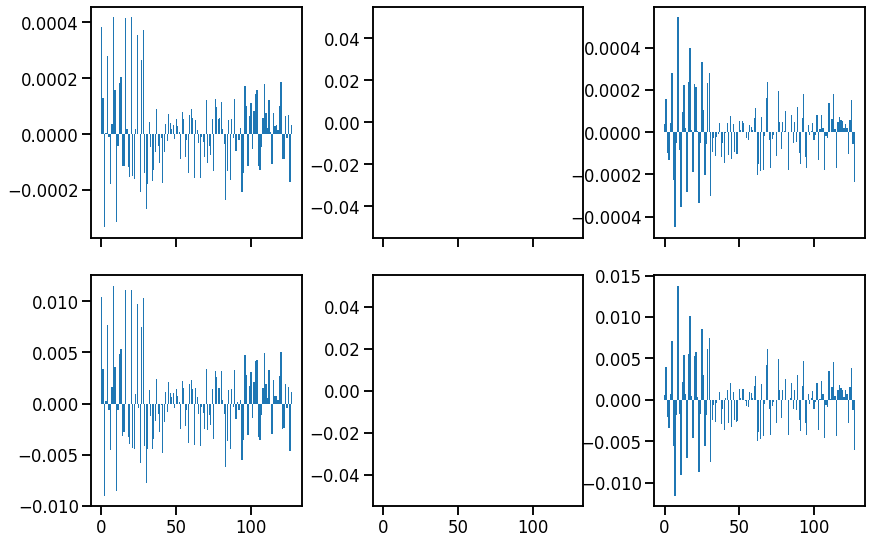

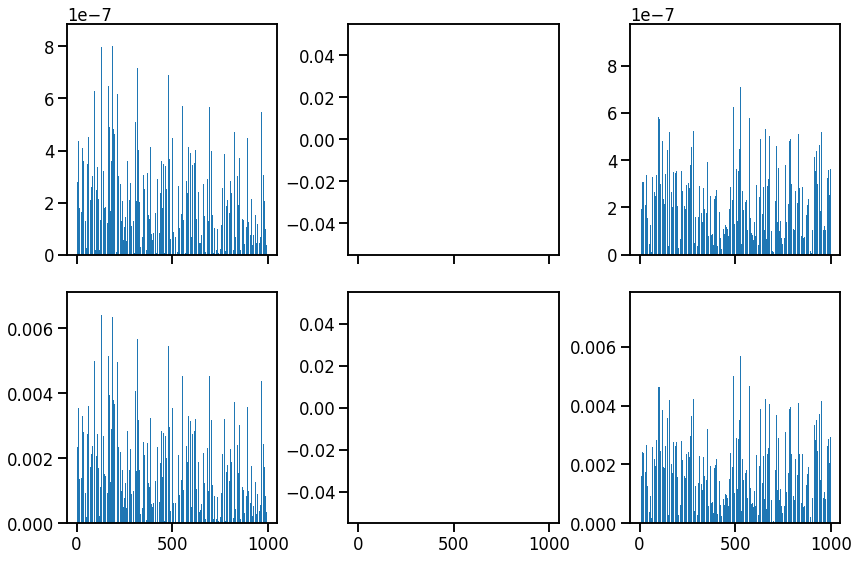

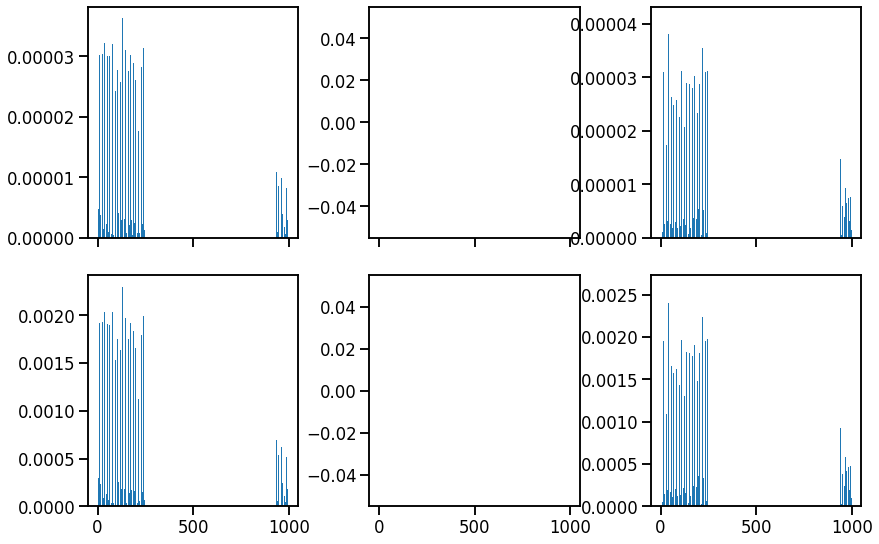

In [20]:



def plot_state_bar(K:np.ndarray, ax =  None, state_names = None):
    """
    K [np.array]: a state variable that records the state
    """
    
    num_state, num_var = K.shape
    
    if num_state >= num_var: print(f'Number of states {num_state} is greater than the {num_var} \n is this intended?')
        
    if ax is None: 
        fig, ax = plt.subplots(2, 3, figsize = (12, 8),sharex =  True)
        fig.tight_layout()
        
    var_pos = np.arange(num_var)
    
    for i in range(3):
        ax[0, i].bar(var_pos, K[i,:])
        ax[1,i].bar(var_pos, K[i + 3,:])
        
    
    
    return ax


K_mat = exp_data_all[0]['feature_selection']['K_mat']
K = K_mat[-1]
k = abs(K)
ax = plot_state_bar(K)

K_mat = exp_data_all[3]['feature_selection']['K_mat']
K = K_mat[-1]

K = abs(K)
ax = plot_state_bar(K)

K_mat = exp_data_all[4]['feature_selection']['K_mat']
K = K_mat[-1]

K = abs(K)
ax = plot_state_bar(K)


In [27]:
feature_selection_data.keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'init_feat_set', 'n_starting_feats', 'n_states', 'no_noise_neuron_ind', 'noise_mode', 'noise_neuron_ind', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

In [28]:
no_noise_neuron_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

(121, 128, 7)
(121, 128, 7)


/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


(121, 128, 7)


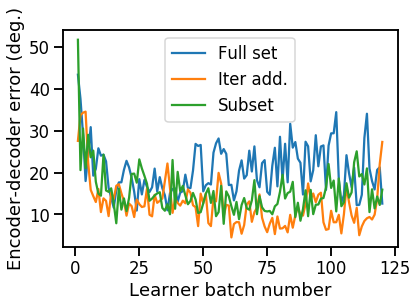

In [29]:
active_feat_set = feature_selection_data['feat_set']
active_feat_set_last = active_feat_set[0]


for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['K_mat']

    dec_directions = np.moveaxis(dec_directions, 2,1)
    print(dec_directions.shape)
    
    

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
    active_angles = np.median(angles_hist[:, no_noise_neuron_ind], axis = 1)
    
    plt.plot(active_angles)

plt.xlabel('Learner batch number')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

## Q mat

In [30]:
feature_selection_data.keys()

dict_keys(['C_mat', 'K_mat', 'Q_diag', 'assist_level', 'batch_size', 'batch_time', 'feat_set', 'fixed_noise_level', 'half_life', 'init_feat_set', 'n_starting_feats', 'n_states', 'no_noise_neuron_ind', 'noise_mode', 'noise_neuron_ind', 'percent_noise', 'sim_C', 'total_exp_time', 'transform_x_flag', 'transform_y_flag'])

Text(0.5, 1.0, 'High SNR neurons')

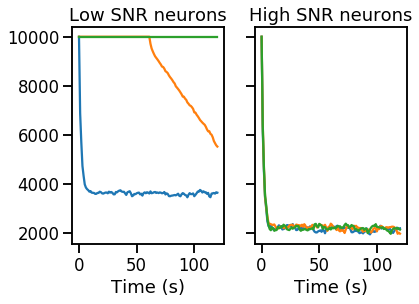

In [31]:
fig_Q, axes_Q = plt.subplots(1,2, sharey = True)

num_noises = 1

from afs_plotting import get_cmap
import matplotlib as mpl

cmap_q = get_cmap(num_noises)

cmap_q_1 = get_cmap(num_noises, mpl.cm.Oranges)

cmap_q_2 = get_cmap(num_noises, mpl.cm.Reds)

for i in range(num_noises):
    
    for j in range(3):


        Q_list = np.array(exp_data_all[j]["feature_selection"]['Q_diag'])



        Q_diag_no_noise = np.mean(Q_list[:, no_noise_neuron_ind], axis = 1)

        Q_diag_noise = np.mean(Q_list[:, noise_neuron_ind], axis = 1)



        axes_Q[0].plot(Q_diag_noise)

        axes_Q[1].plot(Q_diag_no_noise)

    

axes_Q[0].set_xlabel('Time (s)')

axes_Q[1].set_xlabel('Time (s)')



axes_Q[0].set_title('Low SNR neurons')

axes_Q[1].set_title('High SNR neurons')



# Feature analysis

In [ ]:
exp

## examine used C mat

In [32]:
GLOBAL_FIGURE_VERTICAL_SIZE  =  10

fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list

for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C = enc_directions)


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
#axes_compr_means.set_title('Means of the high SNR weight trajectory')

NameError: name 'N_TYPES_OF_NEURONS' is not defined